# 测试

In [3]:
import numpy as np
from IPython.display import display_svg
from tvm import te, build, lower
from tvm_book.testing.relay.viz import graphviz_relay
from tvm.contrib import tedd

In [2]:
A = te.placeholder((1,), name="A")
B = te.placeholder((1,), name="B")
C = te.compute(A.shape, lambda i: A[i] + B[i], name="C")
sch = te.create_schedule(C.op)
ir_mod = lower(sch, [A, B, C], name="test_add")
rt_mod = build(ir_mod, target="llvm")
func = te.create_prim_func([A, B, C])
print(func.script())

# from tvm.script import tir as T
@T.prim_func
def func(A: T.Buffer[1, "float32"], B: T.Buffer[1, "float32"], C: T.Buffer[1, "float32"]) -> None:
    # function attr dict
    T.func_attr({"global_symbol": "main", "tir.noalias": True})
    # body
    # with T.block("root")
    for i0 in T.serial(1):
        with T.block("C"):
            i = T.axis.spatial(1, i0)
            T.reads(A[i], B[i])
            T.writes(C[i])
            C[i] = A[i] + B[i]



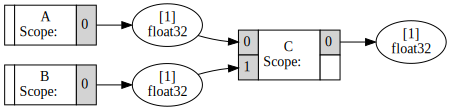

In [5]:
graph = tedd.viz_dataflow_graph(sch, show_svg=True)
display_svg(graph)

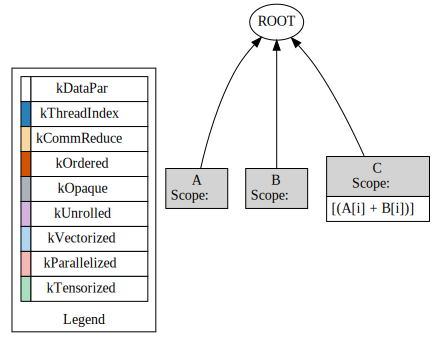

In [6]:
sch = sch.normalize()
tree = tedd.viz_schedule_tree(sch, show_svg=True)

# tedd.viz_schedule_tree(s, dot_file_path="/tmp/scheduletree.dot")
display_svg(tree)

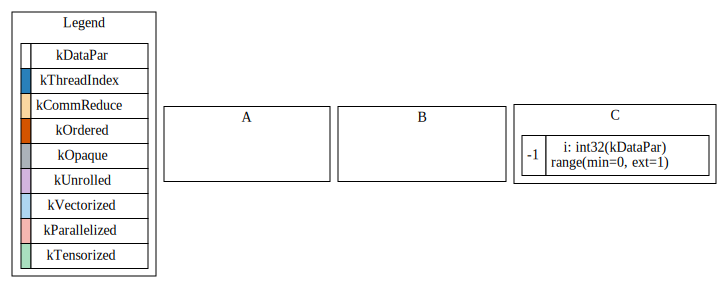

In [7]:
from graphviz import Source
# tedd.viz_itervar_relationship_graph(s, dot_file_path="/tmp/itervar.dot")
dot_string = tedd.viz_itervar_relationship_graph(sch, output_dot_string=True)
src = Source(dot_string)
display_svg(src)

## `te.scan`

In [8]:
m = te.var("m")
n = te.var("n")
X = te.placeholder((m, n), name="X")
s_state = te.placeholder((m, n))
s_init = te.compute((1, n), lambda _, i: X[0, i])
s_update = te.compute((m, n), lambda t, i: s_state[t-1, i] + X[t, i])
res = te.scan(s_init, s_update, s_state, X)
sch = te.create_schedule(res.op)
sch = sch.normalize() # 类型和 shape 推断

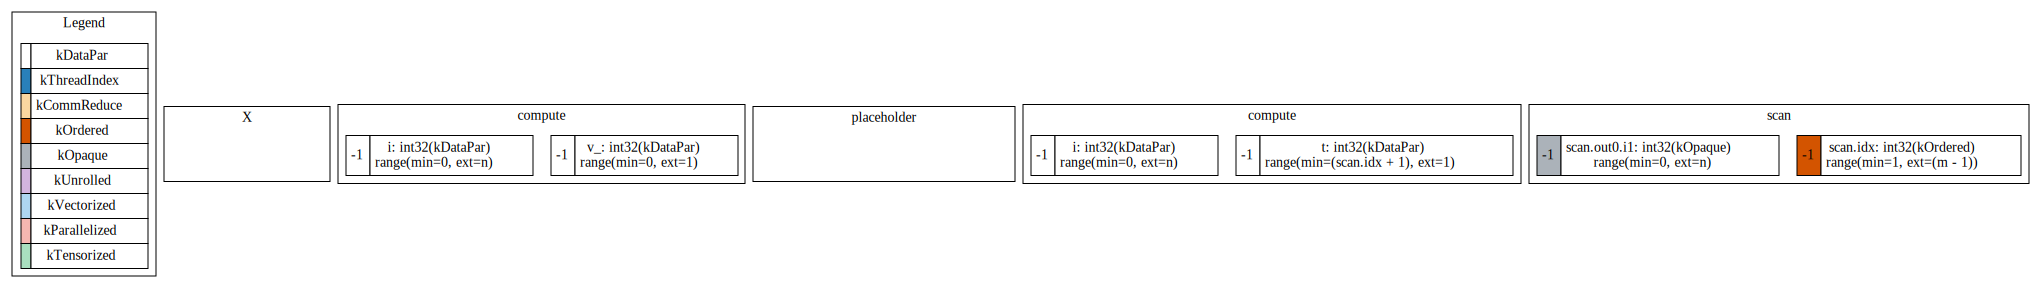

In [9]:
from graphviz import Source
# tedd.viz_itervar_relationship_graph(s, dot_file_path="/tmp/itervar.dot")
dot_string = tedd.viz_itervar_relationship_graph(sch, output_dot_string=True)
src = Source(dot_string)
display_svg(src)

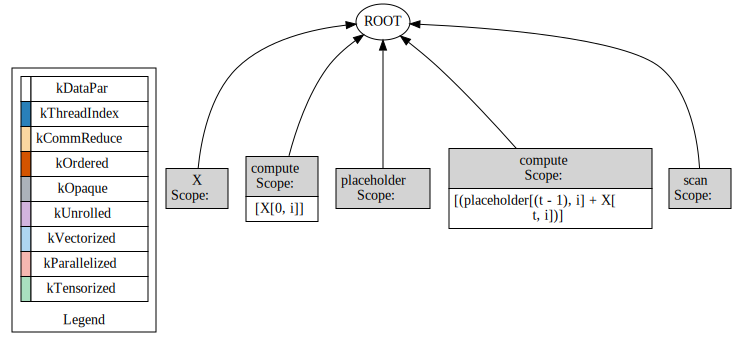

In [10]:
tree = tedd.viz_schedule_tree(sch, show_svg=True)

# tedd.viz_schedule_tree(s, dot_file_path="/tmp/scheduletree.dot")
display_svg(tree)

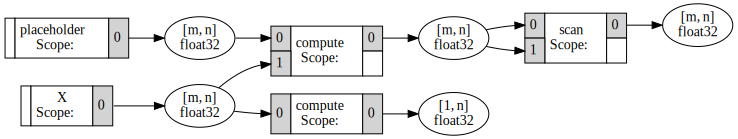

In [11]:
graph = tedd.viz_dataflow_graph(sch, show_svg=True)
display_svg(graph)

## 向量加法

In [12]:
from tvm_book.contrib.d2ltvm import get_abc

In [13]:
a, b, c = get_abc(shape=(1,))

In [14]:
def vector_add(a, b, c):
    n = len(a)
    for i in range(n):
        c[i] = a[i] + b[i]

In [ ]:
vector_add(a, b, c)

In [17]:
from tvm.runtime import load_module

In [18]:
mod_fname = "add.tar"
rt_mod.export_library(mod_fname) # 保存
loaded_mod = load_module(mod_fname) # 加载

## 神经网络